In [1]:
import numpy
import matplotlib.patches as patches
import drjit as dr
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PDE.Coefficient import *
from PDE.utils import *
from PDE.BoundaryShape import *
from PDE.Solver import *
from PDE.Solver.constant.wos_constant import Particle
from PDE import Float,Point2f, GreenSampling, Split, TensorXf

In [2]:
a = TensorXf(np.array([[1,1], [1,1]]))
dr.prod(a.shape)

4

In [3]:
green = GreenSampling.Polynomial
conf_numbers = [UInt32(0), UInt32(1)]
conf_vis = 0
epsilon = 1e-3
use_accel = True
split = Split.Normal

In [4]:
source_p = {}
source_p["radius"] = 0.5
source_p["val"] = 0

def source(points, params):
    return dr.select(dr.norm(points) <= params["radius"], params["val"], 0.0)
f = FunctionCoefficient("f", source_p, source)

In [5]:


def boundary(points, parameters):
    angle = dr.atan2(points[0], points[1])
    return parameters["scale"] * dr.sin(angle * parameters["freq"]) + parameters["bias"]
parameters1_d = {}
parameters1_d["freq"] = 1
parameters1_d["bias"] = 6
parameters1_d["scale"] = 12
parameters2_d = {}
parameters2_d["freq"] = 8
parameters2_d["bias"] = 4
parameters2_d["scale"] = 8

dirichlet1 = FunctionCoefficient("dirichlet", parameters1_d, boundary)
dirichlet2 = FunctionCoefficient("dirichlet", parameters2_d, boundary)


#dirichlet1 = ConstantCoefficient("dirichlet1", 2)
#dirichlet2 = ConstantCoefficient("dirichlet1", )
shape = load_bunny(scale = 1, dirichlet = [dirichlet1, dirichlet2], neumann = [ConstantCoefficient("neumann", 10)], epsilon = epsilon, conf = 2)

In [6]:
bbox = [[-1, -1], [1, 1]]
resolution_image = [256, 256]
spp_image = 256


res = 128
spp_boundary = 2 ** 18

α = ConstantCoefficient("diffusion", 1)


comp_origin = [0.2, -0.2]
comp_radius = 0.2
computation_shape = CircleShape(origin = comp_origin, radius = comp_radius, epsilon = epsilon)

out_val = 1
image = np.arange(32.0) / 32
image = np.tile(image, (32, 1))
image *= 200
image += out_val
σ = TextureCoefficient("screening", bbox = bbox, tensor_np = image, out_val=out_val, grad_zero_points=None)
data_holder = DataHolder(shape = shape, α = α, σ = σ, f=f)


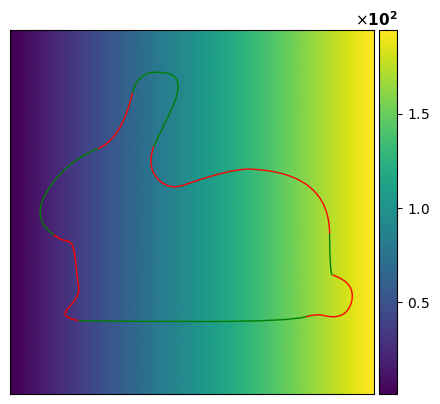

In [7]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
ress = [512, 512]
σ.visualize(ax, bbox, ress)
shape.sketch(ax, bbox, ress)

0 : 16777216 -> 0


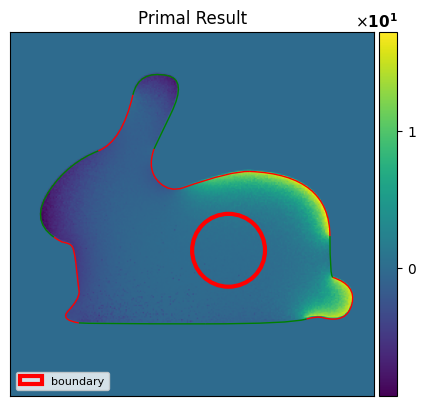

In [8]:
points = create_image_points(bbox, resolution_image, spp_image)
wos = WostVariable(data_holder, green_sampling=green, use_accelaration=use_accel)
L, p = wos.solve(points_in = points, conf_numbers = conf_numbers, split = split)
image_0, tensor = create_image_from_result(L, resolution_image)
fig, (ax1) = plt.subplots(1, 1, figsize=[5, 5])
plot_image(image_0[conf_vis], ax1)
ax1.set_title("Primal Result")
shape.sketch(ax1, bbox, resolution_image)
computation_shape.sketch(ax1, bbox, resolution_image)
ax1.legend(loc = "lower left", fontsize = 8)

In [9]:
dr.width(p.thrown)
dr.sum(dr.select(p.thrown, 1, 0))

[1]

In [10]:
dr.width(p.points)

16777216

In [11]:
points, _, normal_dir = computation_shape.create_boundary_points(distance=0, res = res, spp = spp_boundary)
L, p = wos.solve(points_in = points, conf_numbers = conf_numbers, split = split)
tensor, tensor_mi = computation_shape.create_boundary_result(L, resolution = res)
boundary_dirichlet = computation_shape.create_boundary_coefficient(tensor_mi)

0 : 33554432 -> 0


In [12]:
normal_dir = -dr.normalize(points -Point2f(comp_origin))
L, p = wos.solve(points_in = points, derivative_dir = normal_dir,  conf_numbers=conf_numbers, split = split)
tensor, tensor_mi = computation_shape.create_boundary_result(L, resolution = res)
boundary_neumann= computation_shape.create_boundary_coefficient(tensor_mi)

0 : 33554432 -> 0


Text(0.5, 1.0, 'Dirichlet Cut')

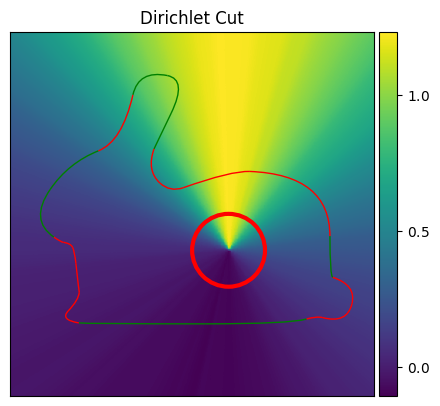

In [13]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
boundary_dirichlet[conf_vis].visualize(ax, bbox, resolution= resolution_image)
shape.sketch(ax, bbox, resolution_image)
computation_shape.sketch(ax, bbox, resolution_image)
ax.set_title("Dirichlet Cut")

Text(0.5, 1.0, 'Neumann Cut')

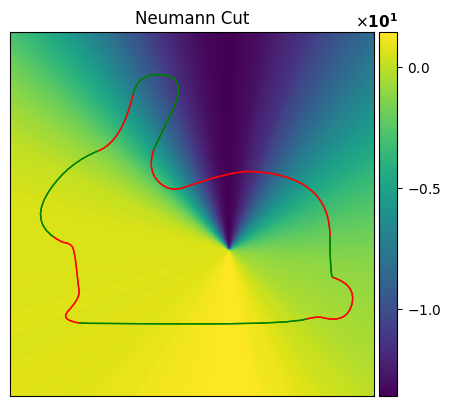

In [14]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
boundary_neumann[0].visualize(ax, bbox, resolution= resolution_image)
shape.sketch(ax, bbox, resolution_image)
shape.sketch(ax, bbox, resolution_image)
ax.set_title("Neumann Cut")

In [15]:
angle_partition1 = np.array([0, 3 * np.pi/4, np.pi, 7 * np.pi / 4])
dirichlet_map1 = np.array([1, 0, 1, 0])

angle_partition2 = np.array([0, 3 * np.pi/4, np.pi, 7 * np.pi / 4])
dirichlet_map2 = np.array([0, 1, 0, 1])
shape1 = CircleShape(origin=comp_origin, radius=comp_radius, epsilon= epsilon,dirichlet=boundary_dirichlet, neumann = boundary_neumann,
                     angle_partition=angle_partition1, dirichlet_map=dirichlet_map1)
data_holder1 = DataHolder(shape = shape1, α = α, σ = σ, f=f)

shape2 = CircleShape(origin=comp_origin, radius=comp_radius, epsilon= epsilon,dirichlet=boundary_dirichlet, neumann = boundary_neumann,
                     angle_partition=angle_partition2, dirichlet_map=dirichlet_map2)
data_holder2 = DataHolder(shape = shape2, α = α, σ = σ, f=f)

In [16]:
bbox_ = [[comp_origin[0] - 1.05 * comp_radius, comp_origin[1] -1.05 * comp_radius], [comp_origin[0] + 1.05 * comp_radius, comp_origin[1] + 1.05 * comp_radius]]
points = create_image_points(bbox_, resolution_image, spp_image)
wos1 = WostVariable(data_holder1, green_sampling = green, use_accelaration=use_accel)
L1, _ = wos1.solve(points_in = points, conf_numbers = conf_numbers, split = split)
image1, tensor = create_image_from_result(L1, resolution_image)
wos2 = WostVariable(data_holder2, green_sampling = green, use_accelaration=use_accel)
L2, _ = wos2.solve(points_in = points, conf_numbers = conf_numbers, split = split)
image2, tensor = create_image_from_result(L2, resolution_image)

0 : 16777216 -> 0
0 : 16777216 -> 0


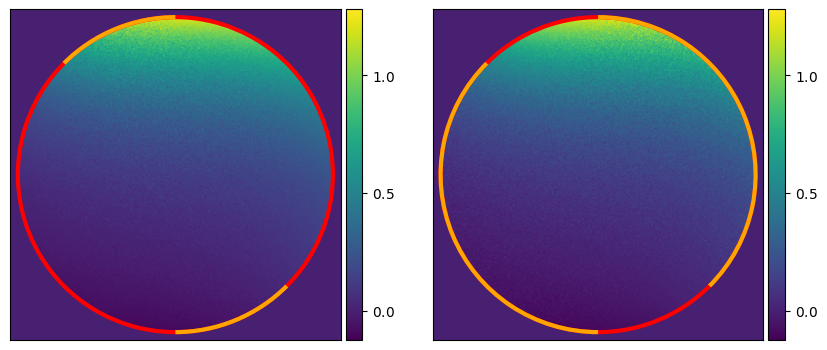

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])
max_val = max(image1.max(), image2.max())
min_val = min(image1.min(), image2.min())
range_ = [min_val, max_val]
plot_image(image1[conf_vis], ax1, input_range=range_)
shape1.sketch(ax1, bbox_, resolution_image)
plot_image(image2[conf_vis], ax2, input_range=range_)
shape2.sketch(ax2, bbox_, resolution_image)

Mean:
0.00010321528
Variance:
0.00047915318


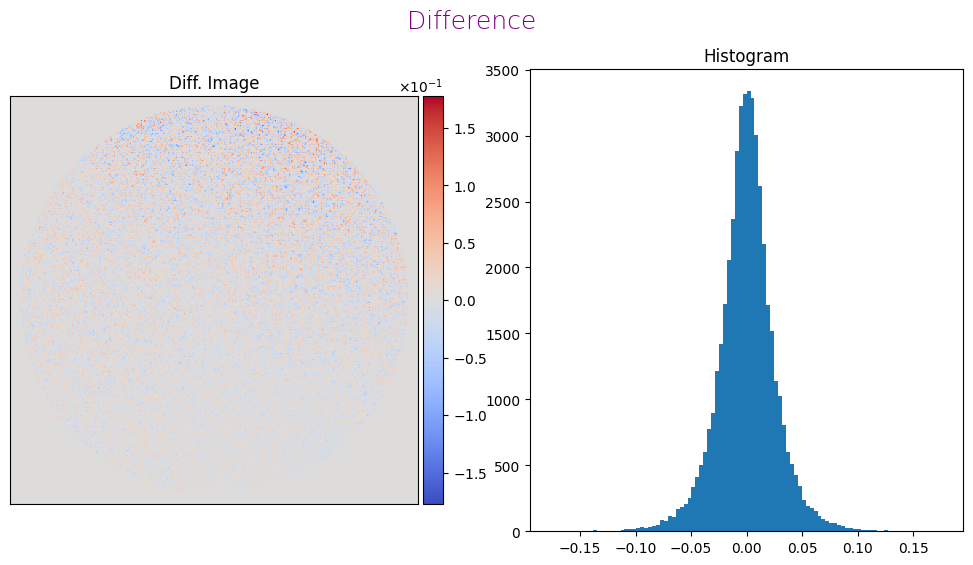

In [18]:
sketch_diff(image1[conf_vis], image2[conf_vis], max_range = 1000)